In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import classification_report
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/datathon-datasciencewomen/AdquisicionAhorroProspectos.csv
/kaggle/input/datathon-datasciencewomen/AdquisicionAhorroHistoricos.csv
/kaggle/input/datathon-datasciencewomen/Submmit_AdquisicionAhorro2.csv


# Funciones

In [3]:
# Funciones para el Univariante
def analisisCategoricas(df, variable):
    frecuencia_absoluta = pd.DataFrame(df[variable].value_counts(dropna = False))
    frecuencia_absoluta.columns = ['FREC_ABS'] 
    #display(frecuencia_absoluta)
    frecuencia_relativa = pd.DataFrame(df[variable].value_counts(normalize = True, dropna = False))
    frecuencia_relativa.columns = ['FREC_REL'] 
    #display(frecuencia_relativa)
    display(pd.concat([frecuencia_absoluta,frecuencia_relativa], axis = 1))

def analisisNumericas(df, variable):
    fig = plt.figure()
    ax = df[variable].plot(kind='hist',grid=True)
    ax.set_title(variable)
    plt.show();
    ax = df[variable].plot(kind='box',grid=True)
    ax.set_title(variable)
    plt.show();

def analizadorNulos(data):
    
    if data.isnull().any().any():
        view_info = pd.DataFrame(pd.concat([data.isnull().any(), data.isnull().sum(), 
                                            round(data.isnull().sum() / qFilas * 100, 2), data.dtypes], axis=1))
        view_info.columns = ['Nulos', 'Cantidad', '%_Nulos', 'Tipo_Dato']
        display(view_info[view_info['Cantidad'] > 0])
    else:
        print("No existen Nulos")

# Funciones para el Bivariante
def discretizarVariable(df, variable, qCortes):

    df[variable + '_D'] = pd.qcut(df[variable], qCortes, duplicates='drop')
    df[variable + '_D'] = df[variable + '_D'].cat.add_categories('Nulo')
    df.loc[df[variable + '_D'].isna(), variable + '_D'] = 'Nulo'

    return df

def analisisBivariante(df, variable, target):
    
    prueba = pd.concat([df.groupby(variable).sum()[[target]].sort_index(), df[variable].value_counts()], axis = 1)
    prueba['%_' + variable] = prueba[target] / prueba[variable]
    fig = plt.figure()
    ax = prueba[variable].plot(kind='bar',grid=True)
    ax.set_title(variable)
    ax2 = ax.twinx()
    ax2.plot(prueba['%_' + variable].values, linestyle='-', linewidth=2.0,color='red')
    rects = ax.patches
    labels = prueba[variable]
    for rect, label in zip(rects, labels):
        height = rect.get_height() 
        ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')
        #ax2.text(rect2.get_x() + rect2.get_width()/2, label, label, ha='center', va='bottom')
    labels2 = prueba['%_' + variable]
    for rect, label2 in zip(rects, labels2):
        ax2.text(rect.get_x() + rect.get_width()/2, label2 + 0.005, "%d%%" % round(label2*100,2), ha='center', va='bottom')
    plt.show();
    #plt.text(0.9, 0.2, 'cos')

# Carga de Bases

In [4]:
df_train = pd.read_csv("/kaggle/input/datathon-datasciencewomen/AdquisicionAhorroHistoricos.csv")
df_test = pd.read_csv("/kaggle/input/datathon-datasciencewomen/AdquisicionAhorroProspectos.csv")

In [5]:
display(df_train.head())
display(df_test.head())

,coddoc,edad,estciv,educacion,mora,balance,vivienda,prestamo,dia,duracion,campana,pdias,previo,Adq_Ahorro
0,CODDOC0001,30.0,married,primaria,no,1787.0,no,no,19.0,79.0,1.0,-1.0,0.0,0
1,CODDOC0002,33.0,married,secundaria,no,4789.0,si,si,11.0,220.0,1.0,339.0,4.0,0
2,CODDOC0003,35.0,single,terciario,no,1350.0,si,no,16.0,185.0,1.0,330.0,1.0,0
3,CODDOC0004,30.0,married,terciario,no,1476.0,si,si,3.0,199.0,4.0,-1.0,0.0,0
4,CODDOC0006,35.0,single,terciario,no,747.0,no,no,23.0,141.0,2.0,176.0,3.0,0


,coddoc,edad,estciv,educacion,mora,balance,vivienda,prestamo,dia,duracion,campana,pdias,previo
0,CODDOC0005,59.0,married,secundaria,no,0.0,si,no,5.0,226.0,1.0,-1.0,0.0
1,CODDOC0007,36.0,married,terciario,no,307.0,si,no,14.0,341.0,1.0,330.0,2.0
2,CODDOC0008,39.0,married,secundaria,no,147.0,si,no,6.0,151.0,2.0,-1.0,0.0
3,CODDOC0012,43.0,married,secundaria,no,264.0,si,no,17.0,113.0,2.0,-1.0,0.0
4,CODDOC0013,36.0,married,terciario,no,1109.0,no,no,13.0,328.0,2.0,-1.0,0.0


In [6]:
df_train.describe(include = 'all')

,coddoc,edad,estciv,educacion,mora,balance,vivienda,prestamo,dia,duracion,campana,pdias,previo,Adq_Ahorro
count,2240,2239.000000,2229,2223,2231,2233.000000,2224,2231,2235.000000,2228.000000,2229.000000,2239.000000,2239.000000,2240.000000
unique,2240,NaN,3,4,2,NaN,2,2,NaN,NaN,NaN,NaN,NaN,NaN
top,CODDOC3776,NaN,married,secundaria,no,NaN,si,no,NaN,NaN,NaN,NaN,NaN,NaN
freq,1,NaN,1386,1125,2198,NaN,1274,1891,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,41.233586,NaN,NaN,NaN,1427.476489,NaN,NaN,15.925280,257.287702,2.836698,37.499777,0.518982,0.115179
std,NaN,10.506367,NaN,NaN,NaN,3121.560598,NaN,NaN,8.243511,248.663958,3.211609,95.014424,1.550021,0.319309
min,NaN,19.000000,NaN,NaN,NaN,-3313.000000,NaN,NaN,1.000000,4.000000,1.000000,-1.000000,0.000000,0.000000
25%,NaN,33.000000,NaN,NaN,NaN,63.000000,NaN,NaN,9.000000,103.000000,1.000000,-1.000000,0.000000,0.000000
50%,NaN,40.000000,NaN,NaN,NaN,439.000000,NaN,NaN,16.000000,181.000000,2.000000,-1.000000,0.000000,0.000000
75%,NaN,48.000000,NaN,NaN,NaN,1506.000000,NaN,NaN,21.000000,318.000000,3.000000,-1.000000,0.000000,0.000000


# Analisis Univariante

In [7]:
# Generar las variables dimensiones
qFilas, qColumnas = df_train.shape
qFilasT, qColumnasT = df_test.shape
print("La cantidad de filas en train: ", qFilas, ", en test:", qFilasT)
print("La cantidad de columnas en train:", qColumnas, ", en test:", qColumnasT)

La cantidad de filas en train:  2240 , en test: 2281
La cantidad de columnas en train: 14 , en test: 13


In [8]:
df_train['Adq_Ahorro'].value_counts(dropna=False, normalize=True)

0    0.884821
1    0.115179
Name: Adq_Ahorro, dtype: float64

In [9]:
varCategoricas = ['estciv','educacion','mora','vivienda','prestamo']
varNumericas = ['edad','balance','dia','duracion','campana','pdias','previo']
varOtras = []

# Analisis Univariante

# Analisis Univariante - Categoricas

In [10]:
for categorica in list(varCategoricas):
    print("------------------------",categorica,"------------------------")
    analisisCategoricas(df_train,categorica)

------------------------ estciv ------------------------


,FREC_ABS,FREC_REL
married,1386,0.618750
single,586,0.261607
divorced,257,0.114732
NaN,11,0.004911


------------------------ educacion ------------------------


,FREC_ABS,FREC_REL
secundaria,1125,0.502232
terciario,662,0.295536
primaria,331,0.147768
desconocido,105,0.046875
NaN,17,0.007589


------------------------ mora ------------------------


,FREC_ABS,FREC_REL
no,2198,0.981250
si,33,0.014732
NaN,9,0.004018


------------------------ vivienda ------------------------


,FREC_ABS,FREC_REL
si,1274,0.568750
no,950,0.424107
NaN,16,0.007143


------------------------ prestamo ------------------------


,FREC_ABS,FREC_REL
no,1891,0.844196
si,340,0.151786
NaN,9,0.004018


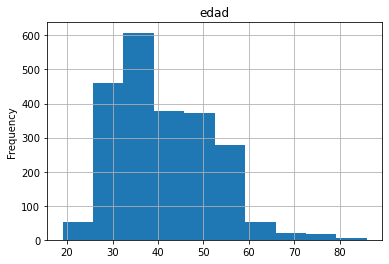

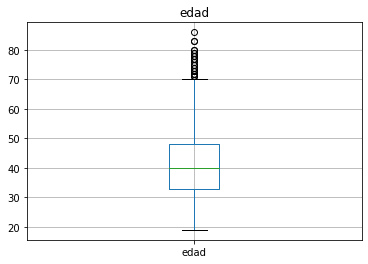

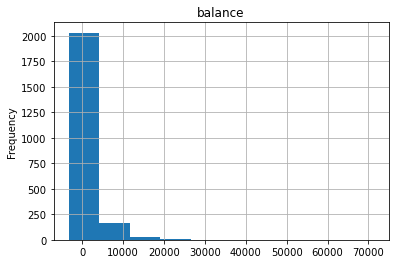

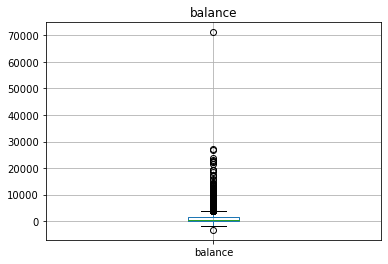

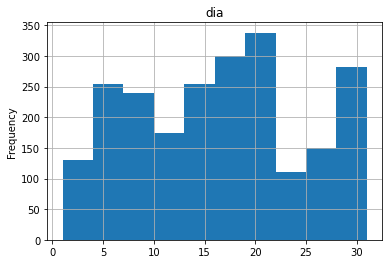

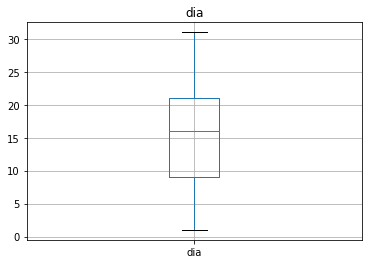

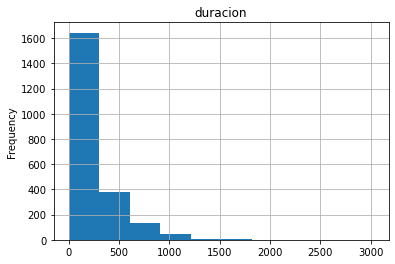

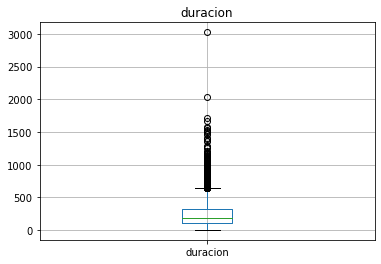

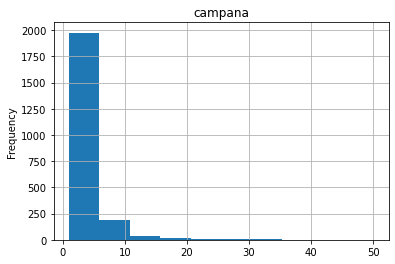

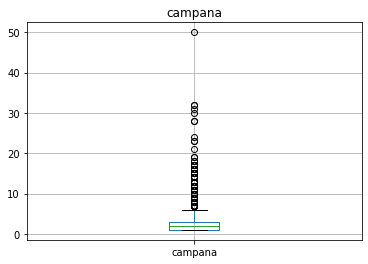

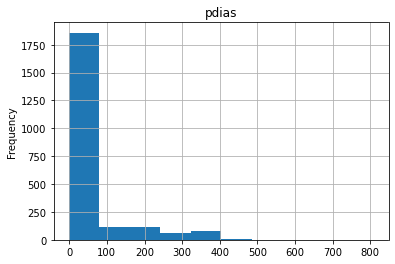

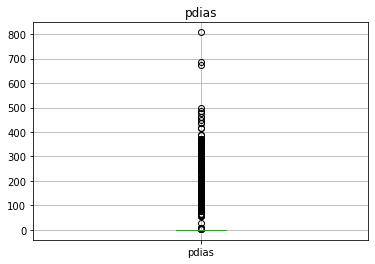

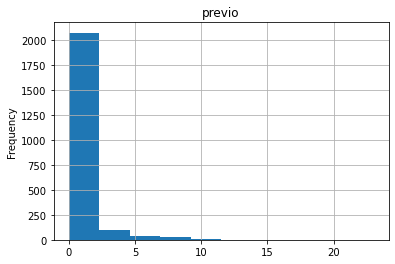

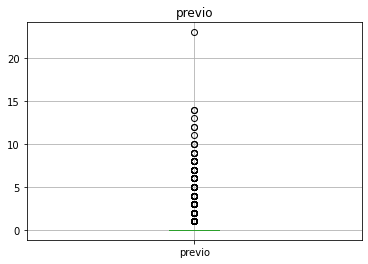

In [11]:
for col in varNumericas:
    analisisNumericas(df_train,col)

# Analisis Bivariante

In [12]:
target = 'Adq_Ahorro'

In [13]:
# Datos agrupados por el TARGET
grouped_data = df_train.groupby('Adq_Ahorro')

In [17]:
# Estadísticas para todas las columnas numéricas por TARGET
grouped_data.describe(include = "all")
# Regresa la media de cada columna numérica por TARGET
grouped_data.median()

,edad,balance,dia,duracion,campana,pdias,previo
Adq_Ahorro,,,,,,,
0,40.0,424.0,16.0,165.0,2.0,-1.0,0.0
1,39.0,648.5,16.0,436.0,2.0,-1.0,0.0


In [ ]:
# Discretizar Variables Numéricas:
for col in varNumericas:
    discretizarVariable(df_train, col, 10)

In [ ]:
# Visualización Variables Numéricas:
for col in varCategoricas + [x + '_D' for x in varNumericas]:
    analisisBivariante(df_train, col, target)

In [ ]:
# Visualización de Variables Categoricas:
for col in varCategoricas:
    analisisBivariante(df_train, col, target)

## Analisis de Nulos

In [ ]:
# Se crea una función que muestra la cantidad de nulos 
analizadorNulos(df_train), analizadorNulos(df_test)

In [ ]:
#############################################
#IMPUTO VARIABLES CATEGORICAS POR LA MODA

for col in varCategoricas:
    mode_ = df_train[col].mode()[0]
    df_train[col].fillna(mode_, inplace = True)
    
for col in varCategoricas:
    mode_ = df_test[col].mode()[0]
    df_test[col].fillna(mode_, inplace = True)

In [ ]:
#############################################
#IMPUTO VARIABLES NUMÉRICAS POR LA MEDIANA

for col in varNumericas:
    median_ = df_train[col].median()
    df_train[col].fillna(median_, inplace = True)
    
for col in varNumericas:
    median_ = df_test[col].median()
    df_test[col].fillna(median_, inplace = True)

# Preprocesamiento

In [ ]:
df_train['contacto'] = df_train['pdias']

In [ ]:
df_test['contacto'] = df_test['pdias']

In [ ]:
df_train['contacto'].loc[df_train.contacto != -1] = 1
df_train['contacto'].loc[df_train.contacto == -1] = 0

In [ ]:
df_test['contacto'].loc[df_test.contacto != -1] = 1
df_test['contacto'].loc[df_test.contacto == -1] = 0

In [ ]:
df_test['contacto'] .value_counts()

In [ ]:
# Educacion
df_train['educacion_N'] = df_train['educacion'].replace(['desconocido','primaria','secundaria','terciario'],[0,1,2,3])
df_test['educacion_N'] = df_test['educacion'].replace(['desconocido','primaria','secundaria','terciario'],[0,1,2,3])
# Combinando Prestamo con Mora
df_train['Prest_Viv'] = df_train['prestamo'] + df_train['vivienda']
df_test['Prest_Viv'] = df_test['prestamo'] + df_test['vivienda']
df_train['Prest_Viv'] = df_train['Prest_Viv'].replace(['nono','nosi','sino','sisi'],[0,1,2,3])
df_test['Prest_Viv'] = df_test['Prest_Viv'].replace(['nono','nosi','sino','sisi'],[0,1,2,3])
# Combinando Prestamo con Mora
df_train['EstCiv_Mora'] = df_train['estciv'] + df_train['mora']
df_test['EstCiv_Mora'] = df_test['estciv'] + df_test['mora']
df_train['EstCiv_Mora'] = df_train['EstCiv_Mora'].replace(['marriedno','marriedsi','singleno','singlesi','divorcedno','divorcedsi'],[0,1,2,3,2,3])
df_test['EstCiv_Mora'] = df_test['EstCiv_Mora'].replace(['marriedno','marriedsi','singleno','singlesi','divorcedno','divorcedsi'],[0,1,2,3,2,3])

In [ ]:
# Estado Civil
df_train['estciv_N'] = df_train['estciv'].replace(['married','single','divorced'], [0,1,1])
df_test['estciv_N'] = df_test['estciv'].replace(['married','single','divorced'], [0,1,1])
# Educacion
df_train['mora_N'] = df_train['mora'].replace(['no','si'],[0,1])
df_test['mora_N'] = df_test['mora'].replace(['no','si'],[0,1])
# Educacion
df_train['vivienda_N'] = df_train['vivienda'].replace(['no','si'],[0,1])
df_test['vivienda_N'] = df_test['vivienda'].replace(['no','si'],[0,1])
# Educacion
df_train['prestamo_N'] = df_train['prestamo'].replace(['no','si'],[0,1])
df_test['prestamo_N'] = df_test['prestamo'].replace(['no','si'],[0,1])

In [ ]:
listVariables_1 = ['edad','educacion_N','balance','dia','duracion',
                 'campana','pdias','contacto','previo','prestamo_N','mora_N','Prest_Viv','estciv_N',
                   'vivienda_N','EstCiv_Mora']
X = df_train[listVariables_1]
Y = df_train[target]

In [ ]:
X.isnull().sum()

In [ ]:
################################################
#IMPORTANCIA DE LAS VARIABLES
################################################
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.ensemble import ExtraTreesClassifier

In [ ]:
################################################
# Seleccion por Random Forest
from sklearn.ensemble import RandomForestClassifier # Paso01: Instancio el algoritmo
forest = RandomForestClassifier()                   # Paso02: Configuro el algoritmo
forest.fit(X, Y)                        # Paso03: Ajuste el algoritmo
importances = forest.feature_importances_           # Variables importantes

In [ ]:
################################################
# Seleccion por Random Forest
TablaImportancia = pd.concat([pd.DataFrame({'Driver':list(X.columns)}),
                              pd.DataFrame({'Importancia':list(forest.feature_importances_)})], axis = 1)
ImportanciaVariables = TablaImportancia[['Driver','Importancia']].sort_values('Importancia', ascending = False).reset_index(drop = True)
ImportanciaVariables

# Modelamiento

In [ ]:
from numpy import loadtxt
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [ ]:
# split data into X and y
#listVariables = ['edad','estciv_N','educacion_N','mora_N','balance','vivienda_N','prestamo_N','dia','duracion',
#                 'campana','pdias','previo'] 
listVariables = ['edad','educacion_N','balance','dia','duracion',
                 'campana','pdias','previo','Prest_Viv', 'EstCiv_Mora'] 
X = X[listVariables]
Y = df_train[target]

# Imputacion de Nulos
#X_noNull = X.fillna(X.median())
#X_test_noNull = df_test.fillna(df_test.median())

In [ ]:
X_test_noNull = df_test[listVariables]

## Grid Search

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in range(50, 1001, 50)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in range(2,8)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10, 30, 50, 100, 150]
# Minimum number of samples required at each leaf node
min_samples_leaf = [2, 5, 10, 30, 50, 100, 150]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Class Weigth
balanced = [None, 'balanced', 'balanced_subsample']
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap,
               'class_weight': balanced}
print(random_grid)

In [ ]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X, Y)

In [ ]:
# Mejores parametros
rf_random.best_params_

### Volvemos al modelo

In [ ]:
## Random Forest
from sklearn.ensemble import RandomForestClassifier
model_rf = RandomForestClassifier(n_estimators=500,
                                  min_samples_split = 5,
                                  min_samples_leaf = 5,
                                  max_features = 'auto',
                                  max_depth = 5,
                                  random_state = 49,
                                  bootstrap = True,
                                  class_weight='balanced')
model_rf.fit(X, Y)

In [ ]:
y_pred_train = model_rf.predict(X[listVariables])

In [ ]:
from sklearn import metrics as metrics
# Matriz de confusion
print("Matriz confusion: Train")
cm_train = metrics.confusion_matrix(Y,y_pred_train)
print(cm_train)

# Accuracy
print("Accuracy: Train")
accuracy_train=metrics.accuracy_score(Y,y_pred_train)
print(accuracy_train)

# Precision
print("Precision: Train")
precision_train=metrics.precision_score(Y,y_pred_train)
print(precision_train)

# Recall
print("Recall: Train")
recall_train=metrics.recall_score(Y,y_pred_train)
print(recall_train)

# ROC_AUC
print("ROC-AUC: Train")
recall_train=metrics.roc_auc_score(Y,y_pred_train)
print(recall_train)

In [ ]:
print(classification_report(Y,y_pred_train))

In [ ]:
# RandomForest
y_pred = model_rf.predict(X_test_noNull[listVariables])
output = pd.DataFrame({'coddoc': df_test.coddoc, 'Adq_Ahorro': y_pred})
output.to_csv('my_submission.csv', index=False)
print("Your submission was successfully saved!")

In [ ]:
# split data into train and test sets
seed = 7
test_size = 0.33
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state=seed)

In [ ]:
# fit model no training data
model = XGBClassifier()
model.fit(X, Y)

In [ ]:
# make predictions for test data
y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]

In [ ]:
# evaluate predictions
accuracy = accuracy_score(y_pred, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

In [ ]:
y_pred = model.predict(df_test[listVariables])

## Random Forest

In [ ]:
## Random Forest
from sklearn.ensemble import RandomForestClassifier
model_rf = RandomForestClassifier(n_estimators=50,
                                 max_depth = 6,
                                 random_state = 49,
                                 max_features = 8,
                                 min_samples_leaf = 10, class_weight='balanced')

In [ ]:
X_noNull = X.fillna(X.mean())
X_test_noNull = df_test.fillna(df_test.mean())

In [ ]:
model_rf = model_rf.fit(X_noNull, Y)

In [ ]:
#Importancia de las variables
features_rf = pd.DataFrame()
features_rf['variable'] = X_noNull.columns
features_rf['Importancia'] = model_rf.feature_importances_
features_rf.sort_values(by = ['Importancia'],ascending=False,inplace = True)
features_rf.head(15)

In [ ]:
# Generar las probabilidades
y_pred_proba = model_rf.predict_proba(X_noNull)[:,1]

# Generar las predicciones:
y_pred = model_rf.predict(X_noNull)

In [ ]:
rf_random.best_params_

In [ ]:
## Random Forest
from sklearn.ensemble import RandomForestClassifier
model_rf = RandomForestClassifier(n_estimators=500,
                                  min_samples_split = 5,
                                  min_samples_leaf = 5,
                                  max_features = 'auto',
                                  max_depth = 5,
                                  random_state = 49,
                                  bootstrap = True,
                                  class_weight='balanced')
model_rf.fit(X_noNull, Y)

In [ ]:
list_thres=np.arange(0,1,0.01)
scores_train_model = []
scores_test_model=[]


thresh = 0.5
def convert_to_bin(vector, thresh = 0.5):
  return([1 if x >= thresh else 0 for x in vector])


for thres in list_thres:
    y_pred_train =  convert_to_bin(y_pred_proba, thres)
    #y_pred_test =  convert_to_bin(y_pred_proba_test, thres)
    scores_train_model.append(accuracy_score(Y, y_pred))
    #scores_test_model.append(accuracy_score(y_test,y_pred_test))

plt.figure(figsize=(8,6))
plt.plot(scores_train_model,label = 'train_accuracy',c='b')
#plt.plot(scores_test_model,label = 'test_accuracy',c='r')
plt.legend()
plt.show()

In [ ]:
output = pd.DataFrame({'coddoc': df_test.coddoc, 'Adq_Ahorro': y_pred})
output.to_csv('my_submission.csv', index=False)
print("Your submission was successfully saved!")

In [ ]:
# RandomForest
y_pred = model_rf.predict(X_test_noNull[listVariables])
output = pd.DataFrame({'coddoc': df_test.coddoc, 'Adq_Ahorro': y_pred})
output.to_csv('my_submission.csv', index=False)
print("Your submission was successfully saved!")

In [ ]:
# RandomForest
y_pred = model_rf.predict(X_test_noNull[listVariables])
output = pd.DataFrame({'coddoc': df_test.coddoc, 'Adq_Ahorro': y_pred})
output.to_csv('my_submission.csv', index=False)
print("Your submission was successfully saved!")